# Exercise: Enron Ensembles

In this exercise we will practice using ensemble methods to build a spam filter trained on the Enron email dataset.

The [Enron Corporation](https://en.wikipedia.org/wiki/Enron) was an energy company active between 1985 and 2004, famous for being investigated for accounting fraud in the "Enron scandal" of 2001. As part of the investigation, the United States Federal Energy Regulatory Commission obtained and published about 500,000 of the company's internal emails. The "silver lining" of the scandal was that this provided NLP researchers working on emails with a convenient dataset.


We will use this data to train a spam filter, using a processed version of the Enron dataset including labels for "ham" (non-spam) and spam emails, provided by the [NLP group at the Athens University of Economics and Business](http://nlp.cs.aueb.gr/software.html) (AUEB). We will compare boosting and bagging and examine how they are applied to this problem.

**Note:** This problem requires scikit-learn version 0.21 or above. Verify that this is installed before proceeding.



In [44]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score,roc_curve,auc,precision_recall_curve,recall_score,classification_report,average_precision_score
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter(action='ignore')

## Part 1: Data preprocessing

### Questions
**1. Load the accompanying data file enron.csv.gz as a Pandas dataframe (use the 'compression' attribute of pandas.read_csv()).** 

In [45]:
enron = pd.read_csv('enron.csv.gz', compression='infer')

enron.head()

,filename,label,text
0,enron1/ham/1061.2000-05-10.farmer.ham.txt,ham,Subject: ena sales on hpl\njust to update you ...
1,enron1/ham/0446.2000-02-18.farmer.ham.txt,ham,Subject: 98 - 6736 & 98 - 9638 for 1997 ( ua 4...
2,enron1/ham/0067.1999-12-27.farmer.ham.txt,ham,"Subject: hpl nominations for december 28 , 199..."
3,enron1/ham/1553.2000-06-29.farmer.ham.txt,ham,"Subject: revised nom - kcs resources\ndaren ,\..."
4,enron1/ham/1790.2000-07-28.farmer.ham.txt,ham,Subject: new production - sitara deals needed\...


Let's look on some statistics

In [46]:
enron.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38891 entries, 0 to 38890
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  38891 non-null  object
 1   label     38891 non-null  object
 2   text      38891 non-null  object
dtypes: object(3)
memory usage: 911.6+ KB


Check for spam/not-spam amount

In [47]:
enron.label.value_counts()/len(enron)*100

spam    53.60109
ham     46.39891
Name: label, dtype: float64

Not big difference: label `spam` we meet more often on ~7%
<br>The data isn't biased too much for now as we can see

**Print out a random ham and spam email.**

In [48]:
spam = enron[enron.label == 'spam'].reset_index()
ham = enron[enron.label == 'ham'].reset_index()

#check if we are correct in spliting
len(spam)+len(ham) == len(enron)

True

In [49]:
import random
s = random.randint(1, len(spam))
h = random.randint(1, len(ham))
print(f"Random spam email:\n \
============================ \
\n{spam.text[s]}\n\n \
Random ham email:\n \
============================ \
\n{spam.text[h]}")

Random spam email:
Subject: i ' m a changed man
dear sir / madam .
we are p prisonhouse leased to introduce ourselves as one of the leading online pharmaceutical sociable shops .
save over 75 ahorse percent on meds today with medz pretext mail shop
overprize vla
r palaeographer a
arranger lal
affiliation lu
oxonian g
cancel c
paratroops is speedily val
predisposition m
sandmanyother .
with each purchas indentation e you get :
top quai christendom ity
best pri victor ces
total confi tightener dentiaiity
home deii blench very
have a nice day .

 Random ham email:
Subject: max , is a good fucker - says bianca . and she suck his cock and musturbating !
hello , i am maryann
teenagers sex / teenmodels hardcore
our site is a porn site collecting young girls from school for exclusive images and videos . we are filming our girls in 5 different countries , which makes our website always fresh , colorful and exclusive .
http : / / shop - site . info / tv /
see you later ,
maryann ibarra



**2. What words do you think would be more common in ham emails?** 

I guess the most common words will be articles, interjections and pronouns, i.e. stop-words.

**What about in spam emails?**

In spam emails i'm sure the same

 **Give a few examples.**

In [50]:
def count_words(df_column,col_names,n):
    
    words = pd.Series(' '.join(df_column).lower().strip().split()).value_counts()
    df = pd.DataFrame(words).reset_index().copy()
    df.columns = col_names
    count_words = df[df[df.columns[0]].str.contains(r'\b[A-Za-z]+\b', case=False)][:n]
    return count_words.reset_index(drop=True).copy()
    

In [51]:
#%%timeit 5.21 s ± 1.28 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

count_words(enron.text,['words','count'],10)

,words,count
0,the,328438
1,to,245725
2,and,182295
3,of,169311
4,a,135621
5,in,121267
6,you,98924
7,for,97720
8,is,82819
9,this,74264


Here we can see exactly articles, interjections , pronouns and conjunctions

**3. How does it look like the text of the emails has been preprocessed by AUEB?**

How? i guess it means, that:
    - all punctuation chars are surrounded with spases as weel the words
    - no any '\t' simbol
    - all words are lowercase()
    - no regular for mail filds(info) about who to who sent the mail
    

**4. Find the most common 20 words in ham emails and the most common 20 words in spam emails. (Hint: use collections.Counter and Pandas str.split() ).** 


Oy, i already wrote the function which makes such search(in the 2 question)
<br> I will just call it here

In [52]:
#create top20 df on each category
ham_top_20 = count_words(ham.text,['ham_words','ham_count'],20)
spam_top_20 = count_words(spam.text,['spam_words','spam_count'],20)

#merge into one df
top_20 = ham_top_20.merge(spam_top_20,left_index=True, right_index=True)
top_20

,ham_words,ham_count,spam_words,spam_count
0,the,195851,the,132587
1,to,140645,to,105080
2,and,90980,and,91315
3,of,83277,of,86034
4,a,70227,a,65394
5,enron,65834,you,61000
6,in,65007,in,56260
7,for,54466,your,44615
8,on,45252,for,43254
9,ect,43127,this,42462


Let's plot all we got

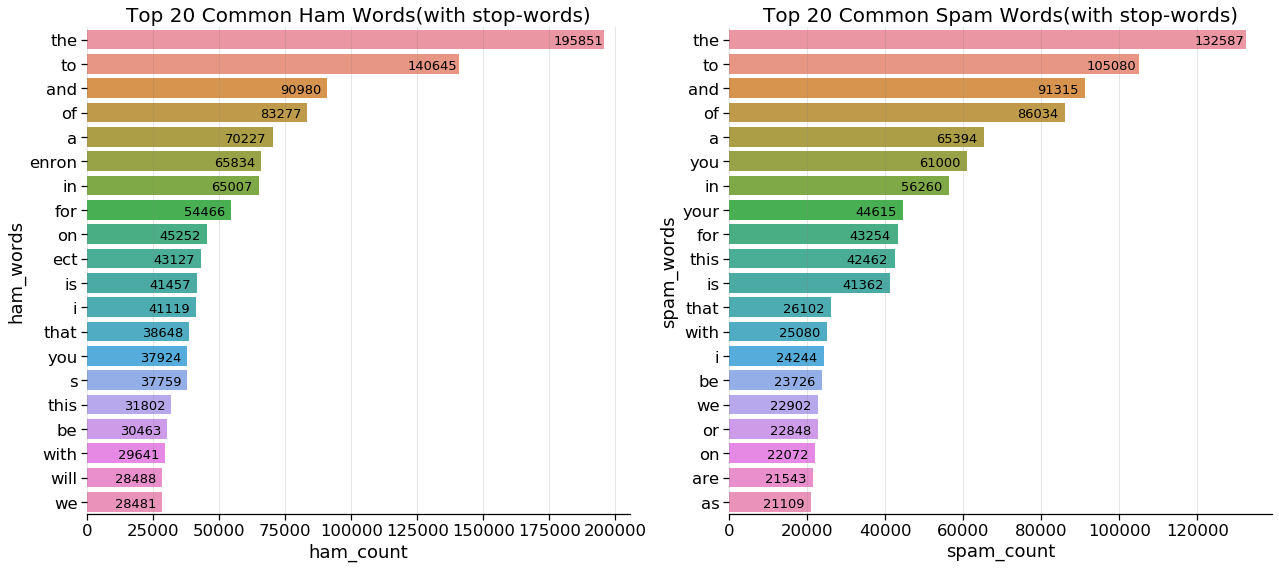

In [53]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (18,8))
#ham
gr = sns.barplot(x=ham_top_20.ham_count.head(20),y=ham_top_20.ham_words.head(20), ax=ax1)
gr.set_title('Top 20 Common Ham Words(with stop-words)', fontsize = 20)
for p in gr.patches:
    width = p.get_width()
    gr.text(width -10000  ,
            p.get_y()+p.get_height()/2+0.2 ,
            f'{int(width)}',
            ha="center", size=13)
ax1.grid(axis='x',which='major',color='grey', alpha=0.2)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)

#spam
g = sns.barplot(spam_top_20.spam_count.head(20),spam_top_20.spam_words.head(20), ax=ax2)
g.set_title('Top 20 Common Spam Words(with stop-words)', fontsize = 20);

for p in g.patches:
    width = p.get_width()
    g.text(width -7000  ,
            p.get_y()+ p.get_height()/2+0.2 ,
            f'{int(width)}',
            ha="center", size=13)
ax2.grid(axis='x',which='major',color='grey', alpha=0.2)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
plt.tight_layout()

**What do you notice about these words?**

I notice, from the table that:
    - first 5 top common words are the same in both categories of mail
    - in ham mails count of  the same top 5 common words is bigger than in spam mails
    - in ham we have the name of the company `enron` and in spam we have no that name in top_20 common words
    - both classes has a very similar to each other set of top20 common words

I would like to see this data not only in the table and without stop-words (i guess it responds to our business goal)
<br>Let's change our function

In [54]:
def count_words_all(df_column,col_names):
    """the function removes all stopwords from the set and counts the words"""
   
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    
    words = pd.Series(' '.join(df_column).lower().split()).value_counts()
    df = pd.DataFrame(words).reset_index().copy()
    df.columns = col_names
    
    count_words = df[df[df.columns[0]].str.contains(r'\b[A-Za-z]+\b', case=False)]
    count_words = count_words[count_words[count_words.columns[0]].apply(lambda x: x not in stop_words)]
    
    return count_words.reset_index(drop=True).copy()

I will create  data frame on each category of the full data set

In [55]:
ham_all = count_words_all(ham.text,['ham_words','ham_count'])
spam_all = count_words_all(spam.text,['spam_words','spam_count'])

[nltk_data] Downloading package stopwords to /home/gal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /home/gal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
ham_all.head(20)

,ham_words,ham_count
0,enron,65834
1,ect,43127
2,hou,19917
3,subject:,18045
4,please,14377
5,would,13440
6,com,13061
7,subject,13032
8,company,11960
9,said,10898


And will plot with special `WordCloud`plot top 20 common words without stopwords

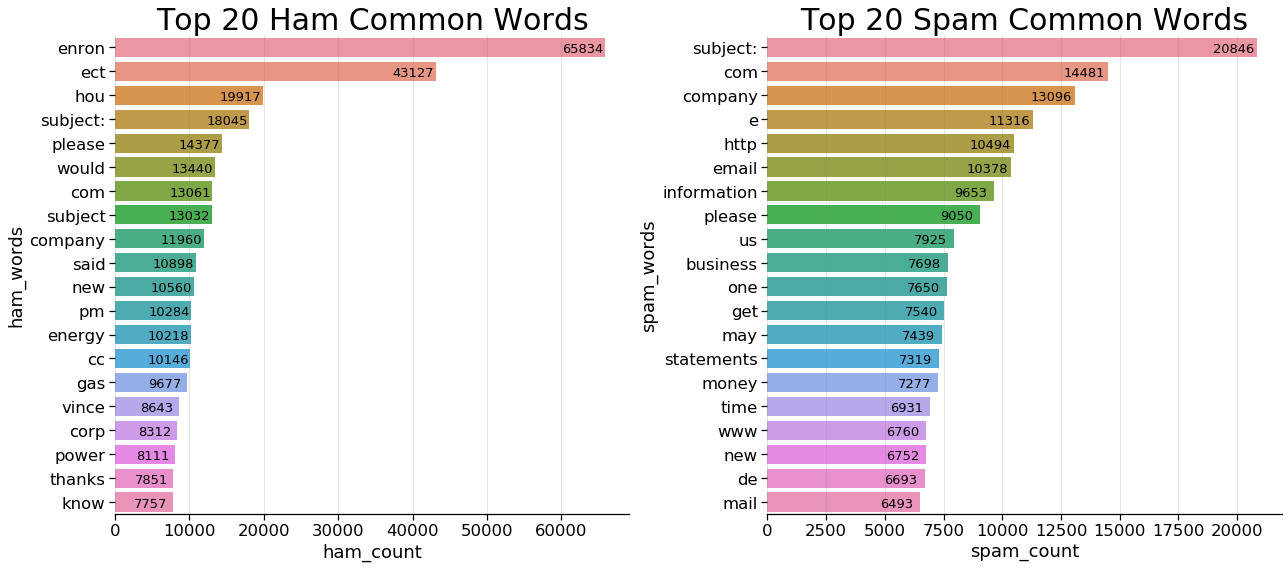

In [57]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (18,8))
#ham
gr = sns.barplot(x=ham_all.ham_count.head(20),y=ham_all.ham_words.head(20), ax=ax1)
gr.set_title('Top 20 Ham Common Words', fontsize = 30)
for p in gr.patches:
    width = p.get_width()
    gr.text(width -3000  ,
            p.get_y()+p.get_height()/2+0.2 ,
            f'{int(width)}',
            ha="center", size=13)
ax1.grid(axis='x',which='major',color='grey', alpha=0.2)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)

#spam
g = sns.barplot(spam_all.spam_count.head(20),spam_all.spam_words.head(20), ax=ax2)
g.set_title('Top 20 Spam Common Words', fontsize = 30);

for p in g.patches:
    width = p.get_width()
    g.text(width -1000  ,
            p.get_y()+ p.get_height()/2+0.2 ,
            f'{int(width)}',
            ha="center", size=13)
ax2.grid(axis='x',which='major',color='grey', alpha=0.2)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
plt.tight_layout()

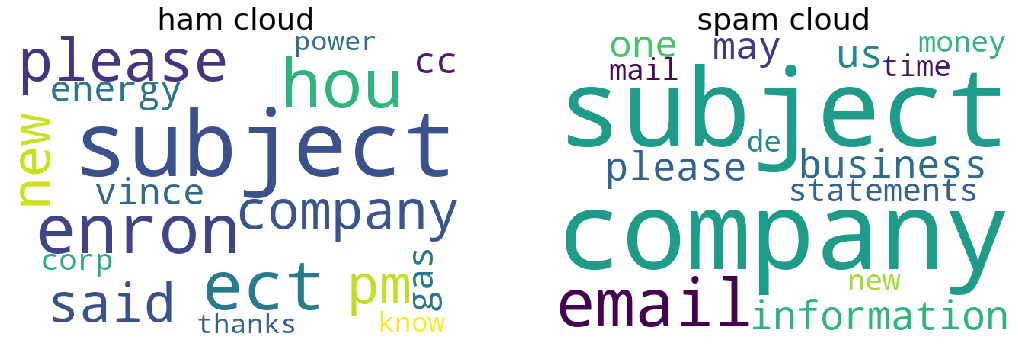

In [58]:
ham_cloud = WordCloud(width = 600, 
                       height = 400, 
                       background_color = 'white').generate(' '.join(ham_all.ham_words.head(20)))
spam_cloud = WordCloud(width = 600,
                      height = 400,
                      background_color = 'white').generate(' '.join(spam_all.spam_words.head(20)))

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (18,8))
ax2.imshow(spam_cloud)
ax2.axis('off')
ax2.set_title('spam cloud', fontsize = 30)
ax1.imshow(ham_cloud)
ax1.axis('off')
ax1.set_title('ham cloud', fontsize = 30);

Now we able to see the real meaning and content of the spam/ham emails:

     -in spam there are more words than in ham
     -some words are realy reapited, but not all now
     -the count of each word in each set(even the same words) is realy different
also i see, that my cleaning words function is not perfect, but at least i tried

**5. Convert the labels (ham/spam) to a numeric vector y, with entries 0 for ham emails and 1 for spam emails. (Hint: y.shape should be (38891,). You might use pandas.Series.map.)**

In [59]:
y = enron.label.replace({'spam': 1, 'ham': 0})

In [60]:
y.shape

(38891,)

**6. Convert the text of emails to a feature matrix X whose rows are "bag of words" feature vectors using sklearn.feature_extraction.text.CountVectorizer, with max_features = 500, stop_words = 'english'. (Hint: X.shape should be (38891, 500)).**

In [61]:
vectorizer = CountVectorizer(max_features = 500, stop_words = 'english')
X = vectorizer.fit_transform(enron.text)
print(f'The X shape after vectorization is{X.shape}')

The X shape after vectorization is(38891, 500)



**7. Look at the first row of X (X[0, :].toarray()).** 

In [62]:
X[0, :].toarray()

array([[0, 0, 0, 0, 0, 1, 2, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 8, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0,
        0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 5, 0, 0, 0, 0, 0, 0, 0, 9, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 7, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

**What do you think each number represents?** 

The index represents the word, so  the meaning of the value
is how many such words are in the first text. 

**Use the CountVectorizer's cv.get_feature_names() or cv.vocabulary_ to confirm your guess.**


In [68]:
ft = vectorizer.get_feature_names() 
print(ft[-5:500])

['world', 'www', 'year', 'years', 'york']


We can see that the list of words is ordered alphabetically. Here is shown the tail of that list

**8. (bonus) Use PCA with two components (sklearn.decomposition.PCA) to project X into two dimensions.** 

In [21]:
pca = PCA(n_components=2)
pca.fit(X.toarray())
X_pca = pca.transform(X.toarray())

**Make a scatterplot of X values with different colors for ham and spam emails.** 

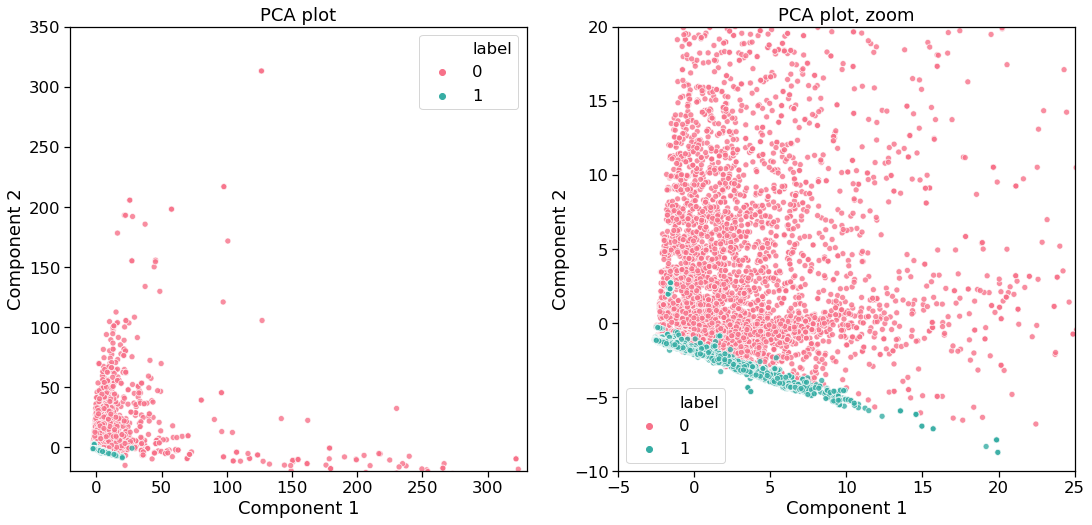

In [22]:
plt.figure(figsize=(18,18))
plt.subplot(2, 2, 1)
g = sns.scatterplot(X_pca[:, 0],X_pca[:, 1], hue = y,legend='full', palette='husl', alpha = 0.8)
plt.xlim(-20,330 )
plt.ylim(-20,350 )
plt.legend()
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('PCA plot');

plt.subplot(2, 2, 2)
sns.scatterplot(X_pca[:, 0],X_pca[:, 1], hue = y, palette='husl', alpha = 0.8)
plt.xlim(-5, 25)
plt.ylim(-10, 20)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('PCA plot, zoom');


**Does it look like the features in X will be useful for identifying spam?**


Yes, it looks like the features in X will be useful for identifying spam. Label 1 represent's spam and we see that almost all dots green color are concentrated in a line (on the right plot)

**9. Split X and y into train and test sets using sklearn.model_selection.train_test_split.**

In [23]:
X_train_abc, X_test_abc, y_train_abc, y_test_abc = train_test_split(X, y, test_size=.2)

**Use 80% of the data for training.**

In [24]:
print(f"""X_train set size:{round(X_train_abc.shape[0]/X.shape[0]*100,2)}%
X_est set size:{round(X_test_abc.shape[0]/X.shape[0]*100,2)}%""")

X_train set size:80.0%
X_est set size:20.0%


In [25]:
print(f'''y_train size :{round(y_train_abc.shape[0]/y.shape[0]*100,2)}%
y_test size :{round(y_test_abc.shape[0]/y.shape[0]*100,2)}%''')

y_train size :80.0%
y_test size :20.0%


## Part 2: Boosting

### Questions:

**10. Train an AdaBoost classifier (sklearn.ensemble.AdaBoostClassifier, using algorithm = 'SAMME') using decision trees of depth one on your training data.**

In [26]:
abc = AdaBoostClassifier(DecisionTreeClassifier (max_depth=1),n_estimators=500,
                         learning_rate=1,algorithm = 'SAMME')
# Train Adaboost Classifer
abc.fit(X_train_abc, y_train_abc)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [27]:
#Predict the response for test dataset
y_pred_abc = abc.predict(X_test_abc)

**Choose whatever number of estimators seems reasonable.**


1. n_estimators=100:
        Accuracy: 0.93
        Precision:0.9
        Recall: 0.98
2. n_estimators=250 
        Accuracy: 0.95
        Precision:0.91
        Recall: 0.99
3. n_estimators=500        
        Accuracy: 0.96
        Precision:0.94
        Recall: 0.99

Well, as you can see, the best result we got with n_estimators = 400 and higher
   

**What accuracy, precision, and recall does this give on the test data?**


In [28]:
print(f"""Accuracy: {round(accuracy_score(y_test_abc, y_pred_abc),2)}
Precision:{round(precision_score(y_test_abc, y_pred_abc),2)}
Recall: {round(recall_score(y_test_abc, y_pred_abc),2)}""")

Accuracy: 0.96
Precision:0.94
Recall: 0.99


In [29]:
report_abc = classification_report(y_test_abc, y_pred_abc)
print(report_abc)

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      3580
           1       0.94      0.99      0.96      4199

    accuracy                           0.96      7779
   macro avg       0.96      0.95      0.96      7779
weighted avg       0.96      0.96      0.96      7779



**11. Which 10 words are most important for knowing if an email is spam? (Hint: use AdaBoostClassifier.feature_importances_ and argsort())** 

In [30]:
list_word = []

features = vectorizer.get_feature_names()

for indx,word in enumerate(features):
    list_word.append({"word":word,"importance": abc.feature_importances_[indx]})
    
top_10_important=pd.DataFrame(list_word).sort_values("importance", ascending = False).head(10)

top_10_important.reset_index(drop=True)

,word,importance
0,enron,0.069135
1,vince,0.044959
2,louise,0.032238
3,2000,0.029509
4,2001,0.029224
5,2005,0.028132
6,california,0.025613
7,attached,0.025210
8,schedule,0.025042
9,713,0.022580


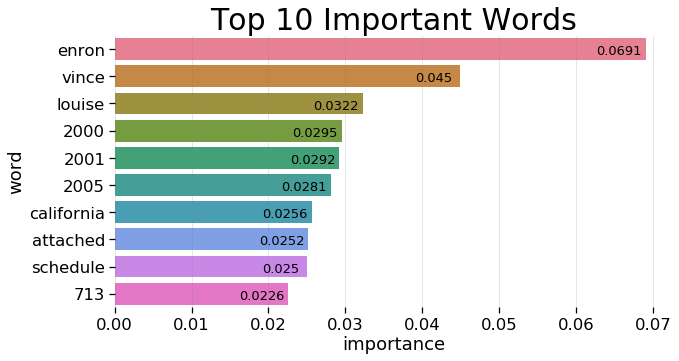

In [31]:
plt.figure(figsize = (10,5))
gr = sns.barplot(x=top_10_important.importance,y=top_10_important.word, palette='husl')
gr.set_title('Top 10 Important Words', fontsize = 30)
for p in gr.patches:
    width = p.get_width()
    gr.text(width -.0035  ,
            p.get_y()+p.get_height()/2+0.2 ,
            f'{width.round(4)}',
            ha="center", size=13)
plt.grid(axis='x',which='major',color='grey', alpha=0.2);
plt.box(on=None);

**Do these make sense to you?**

Yes, because we saw the same (almost the same) list of words highe in the questions.
Also, i want to add a story which i see:
         
         The company `enron` with manager Louice Vince in 2000,2001 and 2005 years was sending a lot of emails           with    attached info about viagra. And It was a bussines letters to the clients, potential buyers
      
Or something like that:

      The company `enron` wich has address Louice Vince st. 713, office N 2005,  in 2000 and 2001  years was          sending a lot of emails  with    attached info about viagra. And It was a bussines letters to the               clients, potential buyers
       


**12. Use AdaBostClassifier.estimators_, AdaBoostClassifier.estimator_weights_, and sklearn.tree.plot_tree to plot the three most important decision trees in the ensemble.  (Hint: in plot_tree use the attributes filled = True, proportion = True, class_names = ['ham', 'spam'], feature_names = [array of words], and set fontsize so that the output is legible.)** 

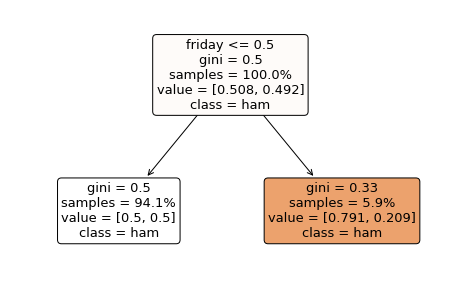

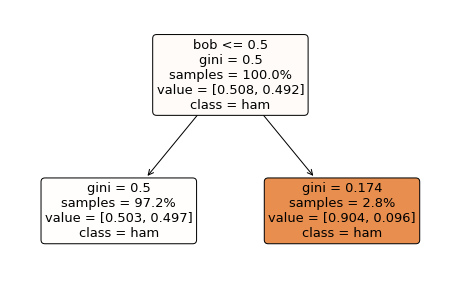

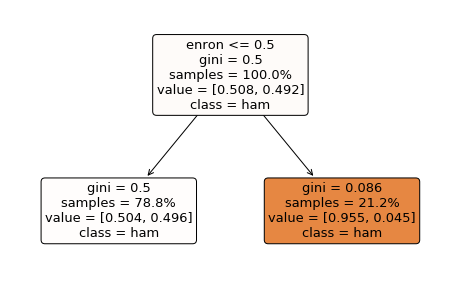

In [32]:
most_important = abc.estimator_weights_.argsort()[:3]

for indx in most_important:
    plt.figure(figsize = (8,5))
    plot_tree(abc.estimators_[indx],
              filled = True,
              max_depth = 1,
              proportion = True,
              class_names = ['ham', 'spam'],
              feature_names = features,
              fontsize = 13,
              rounded = True);

**Would each decision tree alone overfit or underfit?**

In my opinion, each decision tree alone is underfit. It is  bad to have a very low depth exactly because of underfiting

## Part 3: Bagging

### Questions:
**13. Train a Random Forest classifier (sklearn.ensemble.RandomForestClassifier) on the training data.** 

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
print(f"""X_train set size:{round(X_train.shape[0]/X.shape[0]*100,2)}%
X_est set size:{round(X_test.shape[0]/X.shape[0]*100,2)}%\n\n""")
print(f'''y_train size :{round(y_train.shape[0]/y.shape[0]*100,2)}%
y_test size :{round(y_test.shape[0]/y.shape[0]*100,2)}%''')

X_train set size:80.0%
X_est set size:20.0%


y_train size :80.0%
y_test size :20.0%


In [34]:
rfc = RandomForestClassifier(max_depth=10, n_estimators=150, random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [35]:
y_pred = rfc.predict(X_test)

**Choose whatever number of estimators seems reasonable.** 

1. max_depth=10, n_estimators=100:
    
       Accuracy: 0.92
       Precision:0.88
       Recall: 1.0
     
2. max_depth=10, n_estimators=150
     
       Accuracy: 0.93
       Precision:0.88
       Recall: 1.0
     
We see, that when n_estimators=150 with max_depth=10, the scores are the best for this model

**What accuracy, precision, and recall does this give on the test data?**


In [36]:
print(f"""Accuracy: {round(accuracy_score(y_test, y_pred),2)}
Precision:{round(precision_score(y_test, y_pred),2)}
Recall: {round(recall_score(y_test, y_pred),2)}""")


Accuracy: 0.92
Precision:0.87
Recall: 1.0


In [37]:
report_forest = classification_report(y_test, y_pred)
print(report_forest)

              precision    recall  f1-score   support

           0       1.00      0.83      0.91      3639
           1       0.87      1.00      0.93      4140

    accuracy                           0.92      7779
   macro avg       0.94      0.92      0.92      7779
weighted avg       0.93      0.92      0.92      7779



**14. Which 10 words are most important for knowing if an email is spam? (Hint: use RandomForestClassifier.feature_importances_ and argsort())** 

In [38]:
word_list = []

for indx,word in enumerate(features):
    word_list.append({"word":word,"importance": rfc.feature_importances_[indx]})
    
top_10_important=pd.DataFrame(word_list).sort_values("importance", ascending = False).head(10)

top_10_important.reset_index(drop=True)


,word,importance
0,enron,0.118358
1,cc,0.056869
2,2001,0.050289
3,pm,0.035903
4,attached,0.032247
5,2000,0.030890
6,thanks,0.028835
7,vince,0.028295
8,questions,0.027921
9,subject,0.024384


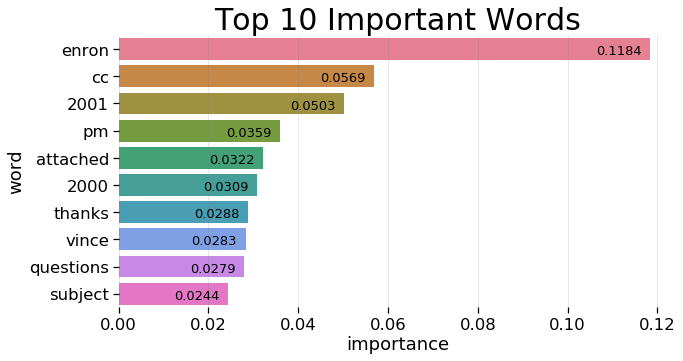

In [39]:

plt.figure(figsize = (10,5))
gr = sns.barplot(x=top_10_important.importance,y=top_10_important.word, palette='husl')
gr.set_title('Top 10 Important Words', fontsize = 30)
for p in gr.patches:
    width = p.get_width()
    gr.text(width -.007  ,
            p.get_y()+p.get_height()/2+0.2 ,
            f'{width.round(4)}',
            ha="center", size=13)
plt.grid(axis='x',which='major',color='grey', alpha=0.2);
plt.box(on=None);

**Do these make sense to you?**


Well, not realy. All i can think only about:
    
     A company `enron` was sending emails with some subject and attachments(maybe to answer the question in the afternoon - `pm`). Mainly all emails where sent in 2000 and 2001 years and it were loking like a bussiness email

**15. Plot any one decision tree from the ensemble, using plot_tree.** 

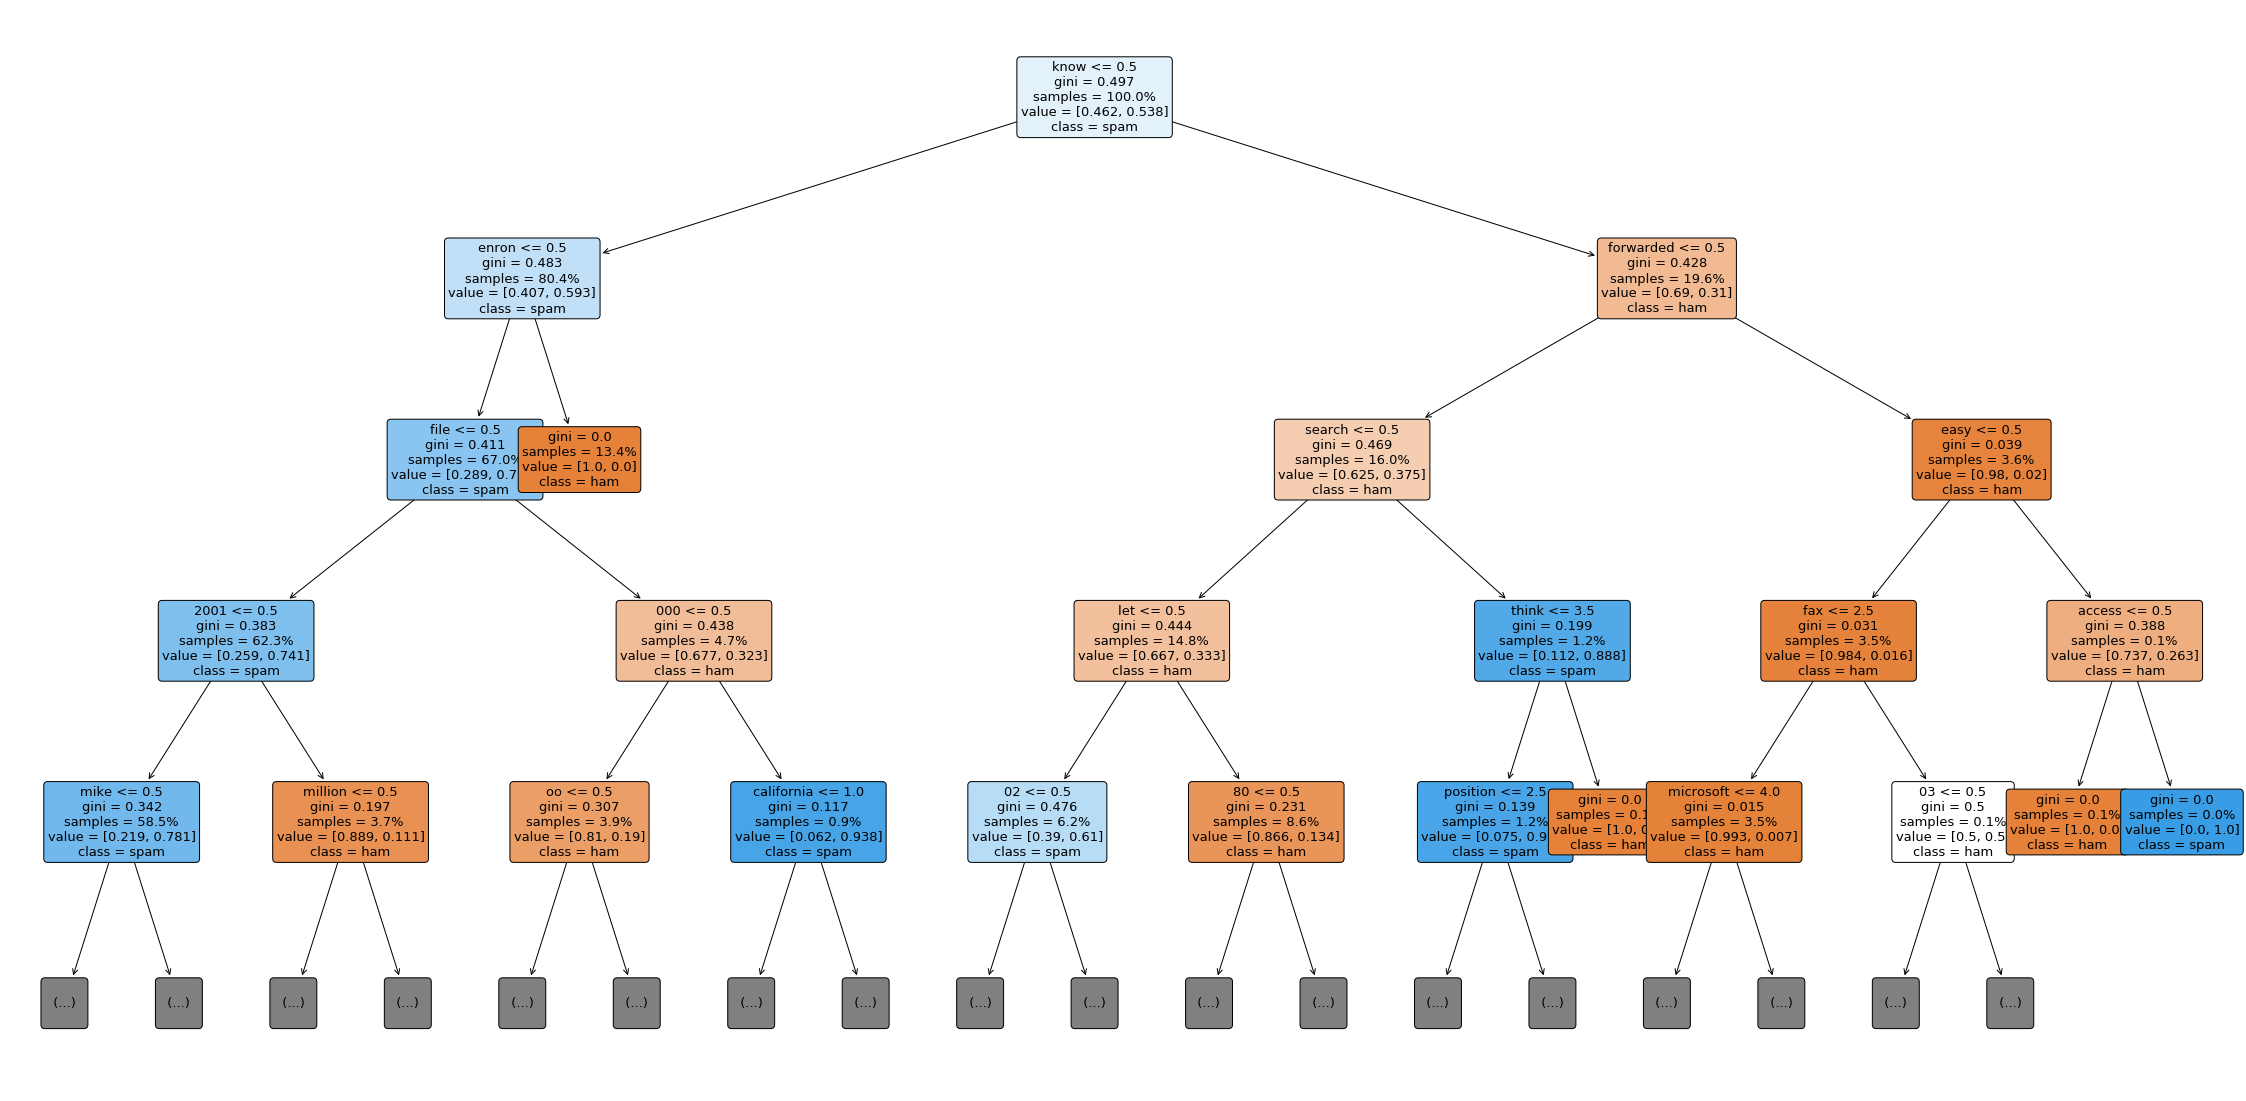

In [40]:
plt.figure(figsize = (40,20))
plot_tree(rfc.estimators_[12],
              filled = True,
              max_depth = 4,
              proportion = True,
              class_names = ['ham', 'spam'],
              feature_names = features,
              fontsize = 13,
              rounded = True);

**Use max_depth to limit the output.** 

max_depth = 4 for output

**Do you think this tree alone would overfit or underfit new data?**

I think This tree alone would overfit 

## Part 4: Analysis

### Question:

**16. Which of the two classifiers that we tested would you prefer for a spam filter, and why?**

In [41]:
print(report_abc)

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      3580
           1       0.94      0.99      0.96      4199

    accuracy                           0.96      7779
   macro avg       0.96      0.95      0.96      7779
weighted avg       0.96      0.96      0.96      7779



In [42]:
print(report_forest)

              precision    recall  f1-score   support

           0       1.00      0.83      0.91      3639
           1       0.87      1.00      0.93      4140

    accuracy                           0.92      7779
   macro avg       0.94      0.92      0.92      7779
weighted avg       0.93      0.92      0.92      7779



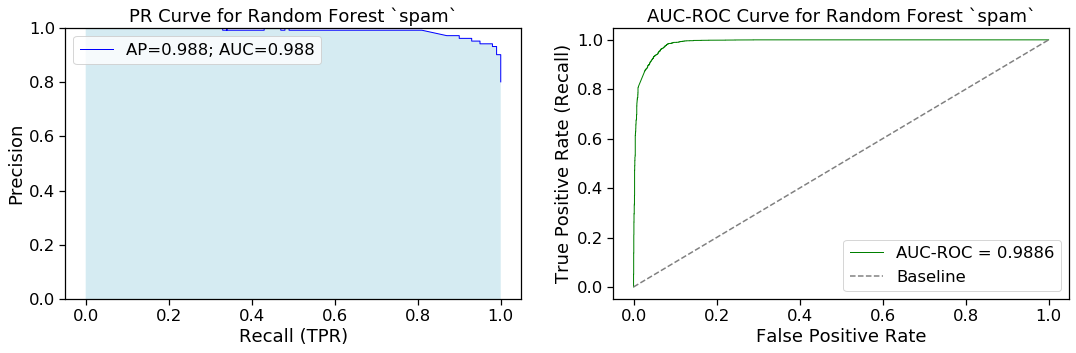

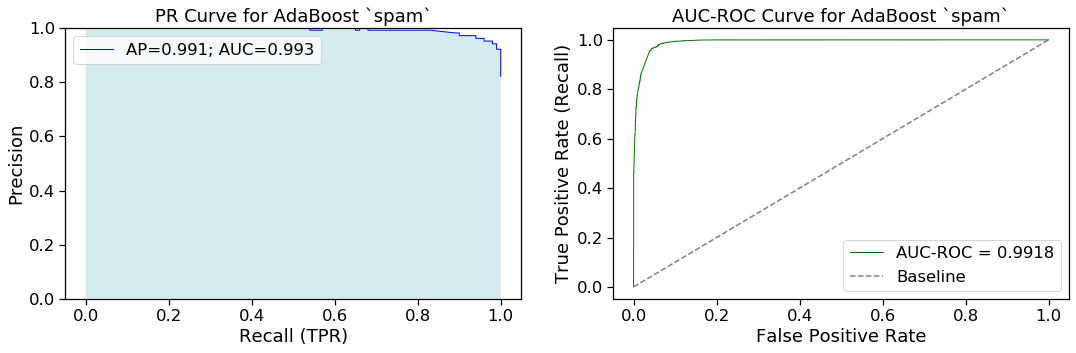

In [43]:
#random forest

fig = plt.figure(figsize = (18,5))
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, rfc.predict_proba(X_test)[:,1], pos_label=1)
precision, recall = np.round(precision, 2), np.round(recall, 2)
# average precision score
avg_precision = average_precision_score(y_test, rfc.predict_proba(X_test)[:,1],pos_label=1)
# precision auc
pr_auc = auc(recall, precision)

ax1 = plt.subplot(121)
ax1.plot(recall, precision, lw=1, color='blue', label=f'AP={round(avg_precision,3)}; AUC={round(pr_auc,3)}') 
plt.fill_between(recall, precision,-1, facecolor='lightblue', alpha=0.5)
plt.xlabel('Recall (TPR)')
plt.ylim(0,1)

plt.ylabel('Precision')
plt.legend(loc="best")
plt.title('PR Curve for Random Forest `spam`');

# calculate AUC-ROC curve
fpr, tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

ax2 = plt.subplot(122)
ax2.plot(fpr, tpr, lw=1, color='green',label=f"AUC-ROC = {round(roc_auc,4)}") 
ax2.plot(ns_fpr, ns_tpr, color='grey',linestyle='--', label='Baseline')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc="best")
plt.title('AUC-ROC Curve for Random Forest `spam`');




#Adaboost

fig = plt.figure(figsize = (18,5))
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test_abc, rfc.predict_proba(X_test_abc)[:,1], pos_label=1)
precision, recall = np.round(precision, 2), np.round(recall, 2)
# average precision score
avg_precision = average_precision_score(y_test_abc, abc.predict_proba(X_test_abc)[:,1],pos_label=1)
# precision auc
pr_auc = auc(recall, precision)

ax1 = plt.subplot(121)
ax1.plot(recall, precision, lw=1, color='blue', label=f'AP={round(avg_precision,3)}; AUC={round(pr_auc,3)}') 
plt.fill_between(recall, precision,-1, facecolor='lightblue', alpha=0.5)
plt.xlabel('Recall (TPR)')
plt.ylim(0,1)

plt.ylabel('Precision')
plt.legend(loc="best")
plt.title('PR Curve for AdaBoost `spam`');

# calculate AUC-ROC curve
fpr, tpr, thresholds = roc_curve(y_test_abc, abc.predict_proba(X_test_abc)[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

ns_probs = [0 for _ in range(len(y_test_abc))]
ns_auc = roc_auc_score(y_test_abc, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test_abc, ns_probs)

ax2 = plt.subplot(122)
ax2.plot(fpr, tpr, lw=1, color='green',label=f"AUC-ROC = {round(roc_auc,4)}") 
ax2.plot(ns_fpr, ns_tpr, color='grey',linestyle='--', label='Baseline')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc="best")
plt.title('AUC-ROC Curve for AdaBoost `spam`');

In fact, both of the two classifiers showed us good scores, we built 2 good accurate modeles.

**Our bussines goal here:** to identify spam, i.e. identify `True Positive` and minimaze `False Positive`
I would choose AdaBoost model, because it has the `Precision ` value higher (0.94-Adaboost vs 0.87-random forest), therefore this model will give us more accurate result with both bussiness important metrics(True Positive and False Positive). So we will got less emails which will go to the folder `spam` and spam itself will be detected more accurete

